In [1]:
import pandas as pd
import os

print("Loading merged dataset from Parquet...")
merged_df = pd.read_parquet("merged_eicu_data.parquet")
print(f"Loaded dataset with {merged_df.shape[0]:,} rows and {merged_df.shape[1]} columns.")

Loading merged dataset from Parquet...
Loaded dataset with 1,908,519 rows and 58 columns.


In [2]:
print("Converting categorical features to numeric...")

categorical_cols = ["gender", "admitsource", "admitdiagnosis"]

from sklearn.preprocessing import LabelEncoder

for col in categorical_cols:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col].astype(str))  # make sure it's str

print("Categorical features converted successfully!")

Converting categorical features to numeric...
Categorical features converted successfully!


In [3]:
print("Converting mortality labels to numeric...")

# Convert mortality labels to 0 (Alive) and 1 (Expired)
merged_df["actualhospitalmortality"] = merged_df["actualhospitalmortality"].replace({"Expired": 1, "Alive": 0})
merged_df["actualhospitalmortality"] = pd.to_numeric(merged_df["actualhospitalmortality"], errors="coerce")

# Fill any remaining NaNs with mode (most likely value)
merged_df["actualhospitalmortality"].fillna(merged_df["actualhospitalmortality"].mode()[0], inplace=True)

print("Mortality labels cleaned and converted to numeric!")

Converting mortality labels to numeric...
Mortality labels cleaned and converted to numeric!


/var/folders/qb/06xhfcmx5yzc7t8swxtczfpw0000gn/T/ipykernel_43817/2194113602.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df["actualhospitalmortality"].fillna(merged_df["actualhospitalmortality"].mode()[0], inplace=True)


In [4]:
merged_df = merged_df.drop(columns=['immunosuppression', 'pco2', 'bilirubin', 'leukemia','acutephysiologyscore','apachescore', 'diabetes', 'gender', 'urine', 'admitsource', 'ventendoffset', 'creatinine', 'pao2', 'hepaticfailure', 'metastaticcancer', 'admissionheight', 'intaketotal_mean', 'meanbp', 'albumin', 'verbal', 'hematocrit', 'hospitaladmitoffset', 'sodium','hospitaldischargeoffset'], errors="ignore")

Optimizing Random Forest Feature Importance Calculation...


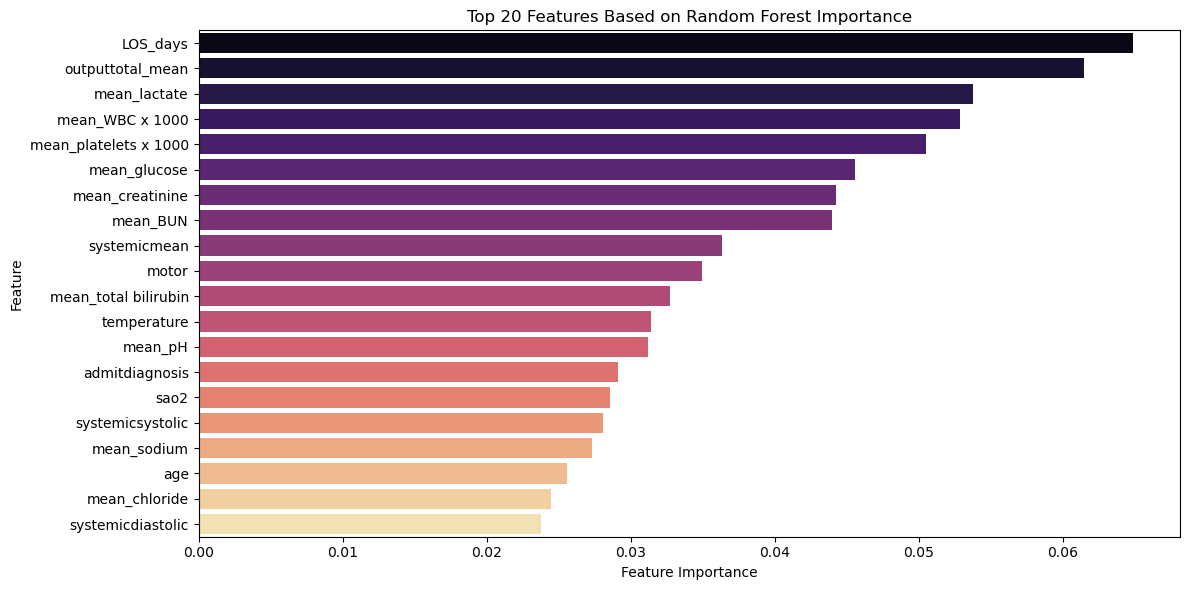

Features with Low Importance (Importance < 0.01): 1 features found.
            Feature  Importance
31  ventstartoffset    0.008337
Features recommended for removal (1 total):
{'ventstartoffset'}


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

print("Optimizing Random Forest Feature Importance Calculation...")

# Define target variable
target = "actualhospitalmortality"

# Extract features and target
features = merged_df.drop(columns=[target])
target_values = merged_df[target]

# Impute missing values
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(features)
y = target_values.values

# Train Random Forest with optimizations
rf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X, y)

# Get feature importances
feature_importances = pd.DataFrame({
    "Feature": features.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Visualizing Feature Importance (Top 20)
plt.figure(figsize=(12, 6))
sns.barplot(
    y=feature_importances["Feature"][:20],
    x=feature_importances["Importance"][:20],
    palette="magma"
)
plt.title("Top 20 Features Based on Random Forest Importance")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Display features with low importance
low_importance_features = feature_importances[feature_importances["Importance"] < 0.01]
print(f"Features with Low Importance (Importance < 0.01): {len(low_importance_features)} features found.")
print(low_importance_features)

# Combine all features that should be removed
features_to_remove = set(low_importance_features["Feature"])
print(f"Features recommended for removal ({len(features_to_remove)} total):")
print(features_to_remove)


In [6]:
merged_df.columns

Index(['age', 'admissionweight', 'wbc', 'respiratoryrate', 'ph', 'bun',
       'glucose', 'actualhospitalmortality', 'motor', 'admitdiagnosis',
       'mean_BUN', 'mean_Hgb', 'mean_WBC x 1000', 'mean_chloride',
       'mean_creatinine', 'mean_glucose', 'mean_lactate', 'mean_pH',
       'mean_paCO2', 'mean_paO2', 'mean_platelets x 1000', 'mean_potassium',
       'mean_sodium', 'mean_total bilirubin', 'heartrate', 'respiration',
       'temperature', 'sao2', 'systemicdiastolic', 'systemicmean',
       'systemicsystolic', 'outputtotal_mean', 'ventstartoffset', 'LOS_days'],
      dtype='object')

In [7]:
merged_df = merged_df.drop(columns=['immunosuppression', 'pco2', 'bilirubin', 'leukemia','acutephysiologyscore','apachescore', 'diabetes', 'gender', 'urine', 'admitsource', 'ventendoffset', 'creatinine', 'pao2', 'hepaticfailure', 'metastaticcancer', 'admissionheight', 'intaketotal_mean', 'meanbp', 'albumin', 'verbal', 'hematocrit', 'hospitaladmitoffset', 'sodium','hospitaldischargeoffset'], errors="ignore")

Computing correlation matrix...


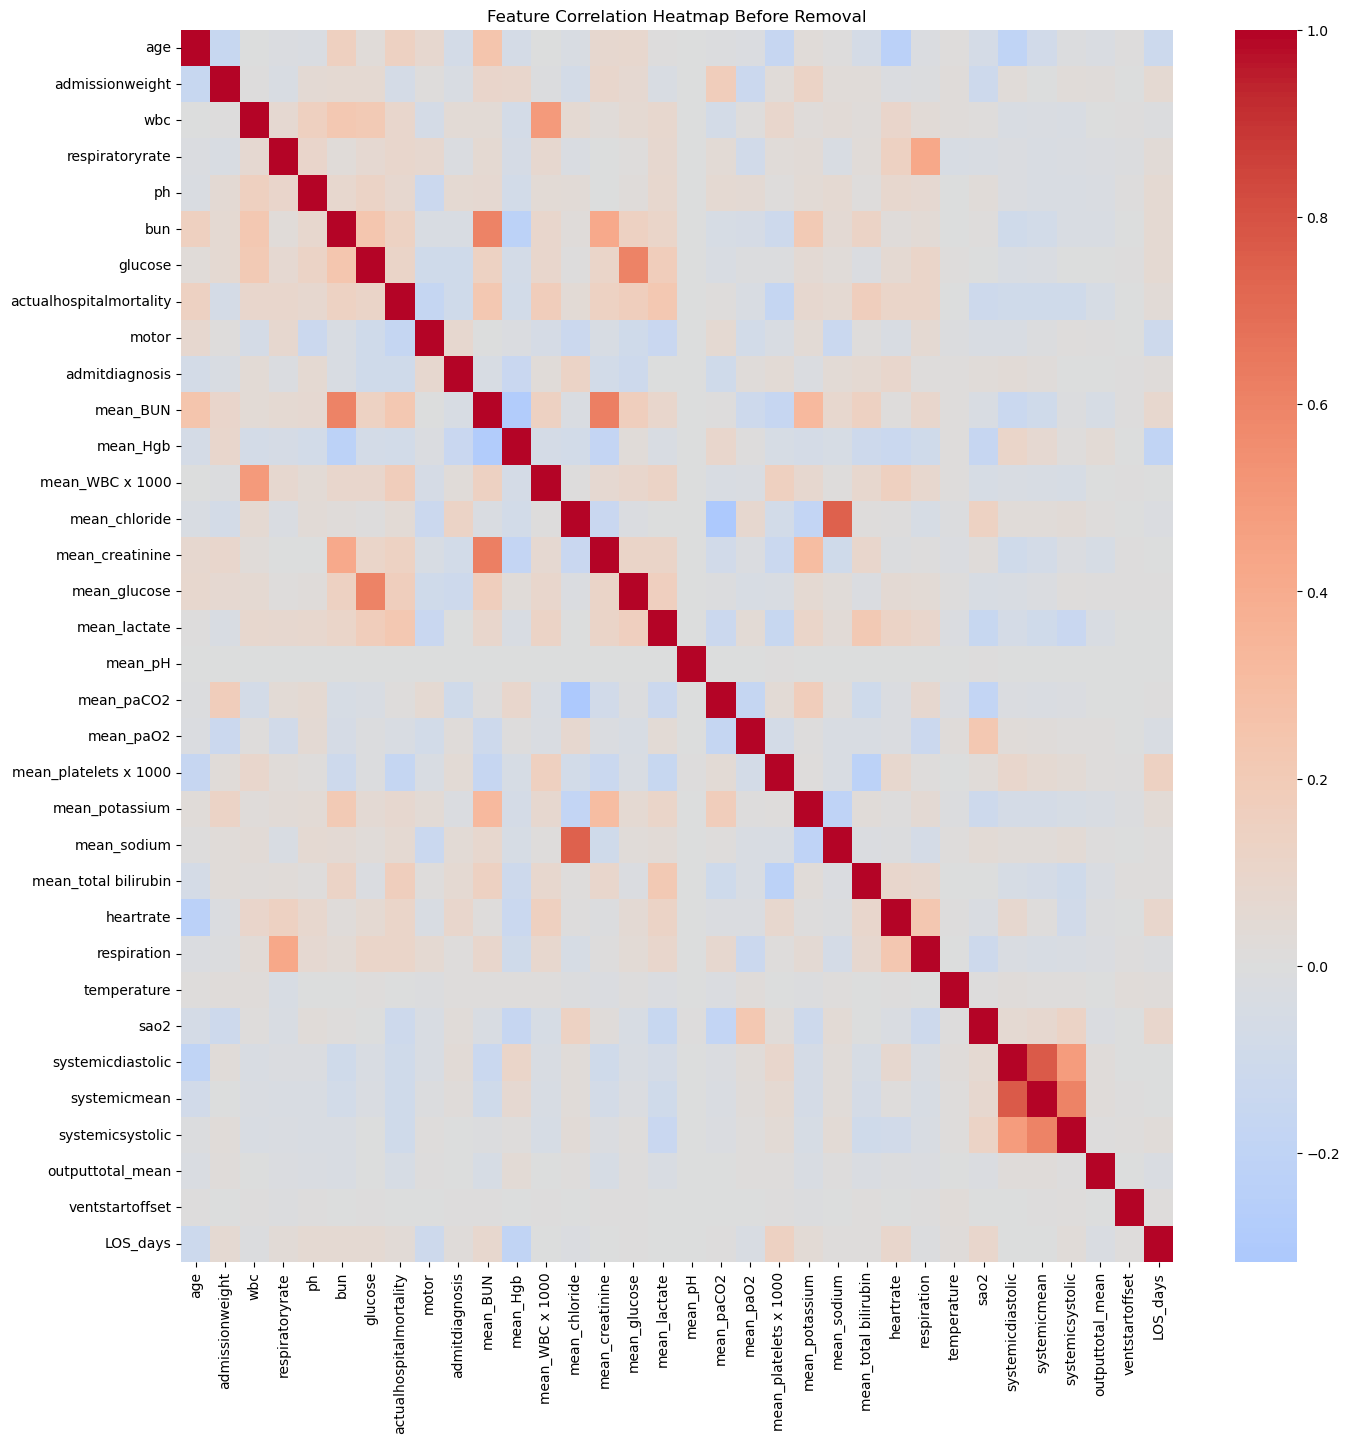

Features with High Correlation (> 0.9):
Empty DataFrame
Columns: [Feature]
Index: []


In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

# Compute correlation matrix
print("Computing correlation matrix...")
corr_matrix = merged_df.corr()

# Identify highly correlated features (absolute correlation > 0.9)
high_corr_features = set()
threshold = 0.9

for col in corr_matrix.columns:
    for index in corr_matrix.index:
        if abs(corr_matrix.loc[col, index]) > threshold and col != index:
            high_corr_features.add(index)

# Visualizing the correlation heatmap before removing features
plt.figure(figsize=(16, 16))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Feature Correlation Heatmap Before Removal")
plt.show()

# Display features to be removed due to high correlation
high_corr_features_df = pd.DataFrame({"Feature": list(high_corr_features)})
print("Features with High Correlation (> 0.9):")
print(high_corr_features_df)


In [9]:
merged_df.columns

Index(['age', 'admissionweight', 'wbc', 'respiratoryrate', 'ph', 'bun',
       'glucose', 'actualhospitalmortality', 'motor', 'admitdiagnosis',
       'mean_BUN', 'mean_Hgb', 'mean_WBC x 1000', 'mean_chloride',
       'mean_creatinine', 'mean_glucose', 'mean_lactate', 'mean_pH',
       'mean_paCO2', 'mean_paO2', 'mean_platelets x 1000', 'mean_potassium',
       'mean_sodium', 'mean_total bilirubin', 'heartrate', 'respiration',
       'temperature', 'sao2', 'systemicdiastolic', 'systemicmean',
       'systemicsystolic', 'outputtotal_mean', 'ventstartoffset', 'LOS_days'],
      dtype='object')

In [10]:
len(merged_df.columns)

34

Optimizing Random Forest Feature Importance Calculation...
 No NaNs in input data. Proceeding to fit the model.


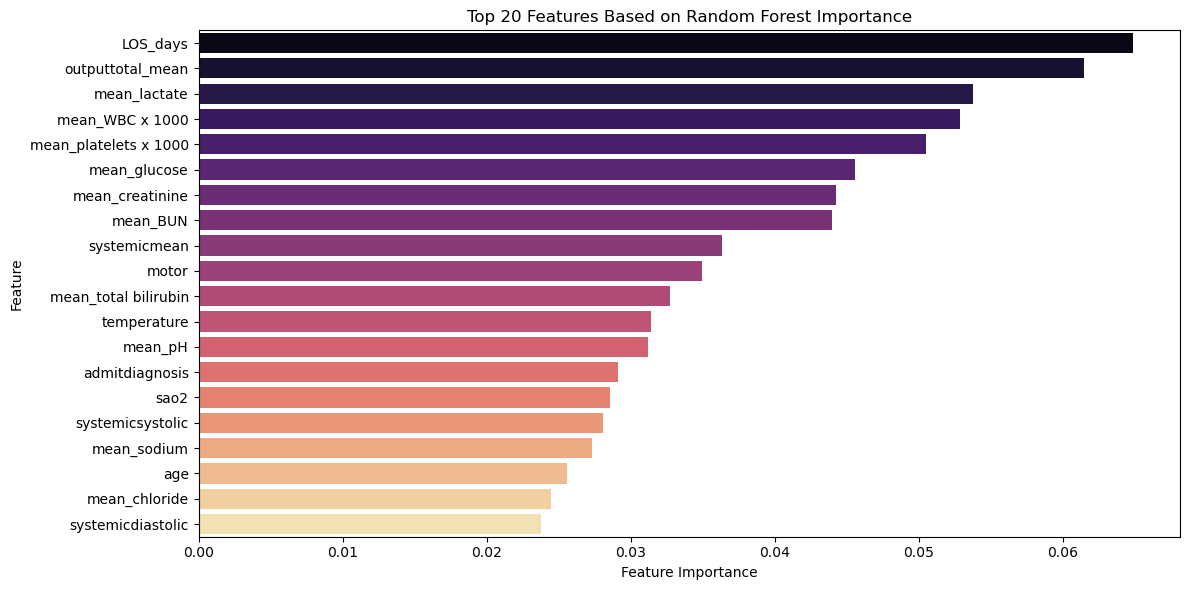

Features with Low Importance (< 0.01): 1
            Feature  Importance
31  ventstartoffset    0.008337
Features recommended for removal (1 total):
{'ventstartoffset'}


In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

print("Optimizing Random Forest Feature Importance Calculation...")

# Define target variable
target = "actualhospitalmortality"

# Extract features and target
features = merged_df.drop(columns=[target])
target_values = merged_df[target]

# Impute missing values using mean
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(features)
y = target_values.values

# Check if any NaNs still exist
if np.isnan(X).any():
    print(" NaNs found even after imputation!")
else:
    print(" No NaNs in input data. Proceeding to fit the model.")

# Train Random Forest
rf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X, y)

# Feature importances
feature_importances = pd.DataFrame({
    "Feature": features.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot Top 20
plt.figure(figsize=(12, 6))
sns.barplot(
    y=feature_importances["Feature"][:20],
    x=feature_importances["Importance"][:20],
    palette="magma"
)
plt.title("Top 20 Features Based on Random Forest Importance")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Show features with low importance
low_importance_features = feature_importances[feature_importances["Importance"] < 0.01]
print(f"Features with Low Importance (< 0.01): {len(low_importance_features)}")
print(low_importance_features)

# List features to remove
features_to_remove = set(low_importance_features["Feature"])
print(f"Features recommended for removal ({len(features_to_remove)} total):")
print(features_to_remove)


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

print("Computing Mutual Information with Single-Core Processing...")

# Define target variable
target = "actualhospitalmortality"
features = merged_df.drop(columns=[target])
target_values = merged_df[target]

# Convert to NumPy Arrays
X_np = features.to_numpy()
# Fill NaNs with median (robust for clinical data)
X_np = features.fillna(features.median()).to_numpy()
y_np = target_values.to_numpy()

# Compute MI with Single-Core Processing
mi_scores = mutual_info_classif(X_np, y_np, discrete_features="auto")

# Convert results to DataFrame
mi_scores_df = pd.DataFrame({"Feature": features.columns, "MI Score": mi_scores})
mi_scores_df = mi_scores_df.sort_values(by="MI Score", ascending=False)

# Visualizing Mutual Information Scores
plt.figure(figsize=(12, 6))
sns.barplot(y=mi_scores_df["Feature"][:20], x=mi_scores_df["MI Score"][:20], palette="viridis")
plt.title("Top 20 Features Based on Mutual Information")
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.show()

print("MI Computation Completed Using Single-Core Processing!")

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Optimizing Random Forest Feature Importance Calculation...")

# Target variable
target = "actualhospitalmortality"
features = merged_df.drop(columns=[target])
target_values = merged_df[target]

# Impute missing values before training
imputer = SimpleImputer(strategy='median')  # median is robust for clinical data
X = imputer.fit_transform(features)         # fills and transforms in one step
y = target_values.values

# Final safety check
if np.isnan(X).any():
    raise ValueError("X still contains NaNs after imputation!")

# Train Random Forest
rf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X, y)

# Feature importance DataFrame
feature_importances = pd.DataFrame({
    "Feature": features.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Visualize top 20
plt.figure(figsize=(12, 6))
sns.barplot(
    y=feature_importances["Feature"][:20],
    x=feature_importances["Importance"][:20],
    palette="magma"
)
plt.title("Top 20 Features Based on Random Forest Importance")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Print low importance features
low_importance_features = feature_importances[feature_importances["Importance"] < 0.01]
print(f"Features with Low Importance (< 0.01): {len(low_importance_features)}")
print(low_importance_features)

# Store features to remove
features_to_remove = set(low_importance_features["Feature"])
print(f"Features recommended for removal ({len(features_to_remove)} total):")
print(features_to_remove)


In [12]:
merged_df.columns

Index(['age', 'admissionweight', 'wbc', 'respiratoryrate', 'ph', 'bun',
       'glucose', 'actualhospitalmortality', 'motor', 'admitdiagnosis',
       'mean_BUN', 'mean_Hgb', 'mean_WBC x 1000', 'mean_chloride',
       'mean_creatinine', 'mean_glucose', 'mean_lactate', 'mean_pH',
       'mean_paCO2', 'mean_paO2', 'mean_platelets x 1000', 'mean_potassium',
       'mean_sodium', 'mean_total bilirubin', 'heartrate', 'respiration',
       'temperature', 'sao2', 'systemicdiastolic', 'systemicmean',
       'systemicsystolic', 'outputtotal_mean', 'ventstartoffset', 'LOS_days'],
      dtype='object')

In [13]:
expected_columns=['age', 'admissionweight', 'respiratoryrate', 'ph', 'bun', 'glucose',
       'motor', 'mean_BUN', 'mean_Hgb', 'mean_WBC x 1000', 'mean_chloride',
       'mean_creatinine', 'mean_glucose', 'mean_lactate', 'mean_pH',
       'mean_paCO2', 'mean_paO2', 'mean_platelets x 1000', 'mean_potassium',
       'mean_sodium', 'mean_total bilirubin', 'heartrate', 'respiration',
       'temperature', 'sao2', 'systemicdiastolic', 'systemicmean',
       'systemicsystolic', 'outputtotal_mean', 'LOS_days','actualhospitalmortality']
merged_df = merged_df[expected_columns]

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
import dask.dataframe as dd

print("Checking DataFrame Type Before Computing...")

# Ensure merged_df is a Pandas DataFrame
if isinstance(merged_df, dd.DataFrame):
    print("Converting from Dask to Pandas...")
    merged_df = merged_df.compute()
else:
    print("Already a Pandas DataFrame—skipping `.compute()`.")

# Define target and features
target = "actualhospitalmortality"
X = merged_df.drop(columns=[target])
y = merged_df[target]

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Data split completed: Train size = {X_train.shape}, Test size = {X_test.shape}")

Checking DataFrame Type Before Computing...
Already a Pandas DataFrame—skipping `.compute()`.
Data split completed: Train size = (1526815, 30), Test size = (381704, 30)


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

print("Training Random Forest with Class Balancing...")

rf_model = RandomForestClassifier(
    n_estimators=100, max_depth=10, class_weight="balanced", 
    random_state=42, n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate Performance
print("Random Forest Performance with Class Balancing:")
print(classification_report(y_test, y_pred_rf))

Training Random Forest with Class Balancing...
Random Forest Performance with Class Balancing:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97    297498
         1.0       0.89      0.90      0.90     84206

    accuracy                           0.95    381704
   macro avg       0.93      0.94      0.93    381704
weighted avg       0.95      0.95      0.95    381704



In [16]:
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Step 1: Impute missing values in X_train
imputer = SimpleImputer(strategy='mean')  # You can also use 'median' if preferred
X_train_imputed = imputer.fit_transform(X_train)

# Step 2: Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_imputed, y_train)

print("SMOTE applied successfully on imputed data!")

SMOTE applied successfully on imputed data!


In [17]:
import xgboost as xgb

print("Training XGBoost...")
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, use_label_encoder=False)
xgb_model.fit(X_resampled, y_resampled)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate performance
print("XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb))

Training XGBoost...


/Users/parthshiroya/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:45:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Performance:
              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96    297498
         1.0       0.83      0.93      0.87     84206

    accuracy                           0.94    381704
   macro avg       0.90      0.94      0.92    381704
weighted avg       0.95      0.94      0.94    381704



In [18]:
import lightgbm as lgb

print("Training LightGBM...")
lgb_model = lgb.LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
lgb_model.fit(X_resampled, y_resampled)

# Predictions
y_pred_lgb = lgb_model.predict(X_test)

# Evaluate performance
print("LightGBM Performance:")
print(classification_report(y_test, y_pred_lgb))

Training LightGBM...
[LightGBM] [Info] Number of positive: 1189991, number of negative: 1189991
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7583
[LightGBM] [Info] Number of data points in the train set: 2379982, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Performance:
              precision    recall  f1-score   support

         0.0       0.98      0.93      0.95    297498
         1.0       0.78      0.92      0.84     84206

    accuracy                           0.92    381704
   macro avg       0.88      0.92      0.90    381704
weighted avg       0.93      0.92      0.93    381704



In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

print("Preparing Data for Neural Network...")

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
# Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_resampled.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# Define a simple Feedforward Neural Network
class ICU_NN(nn.Module):
    def __init__(self, input_size):
        super(ICU_NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Initialize Model
input_size = X_train.shape[1]
model = ICU_NN(input_size)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train Model
print("Training Neural Network...")
num_epochs = 10
for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Neural Network Training Completed!")

# Evaluate Model
with torch.no_grad():
    y_pred_nn = model(X_test_tensor).squeeze()

    # Clamp predictions to avoid values outside [0, 1]
    y_pred_nn = torch.clamp(y_pred_nn, min=0.0, max=1.0)

    # Convert predictions to binary (0 or 1)
    y_pred_labels = torch.round(y_pred_nn)

    # Check for NaNs before evaluation
    if torch.isnan(y_pred_labels).any():
        nan_count = torch.isnan(y_pred_labels).sum().item()
        print(f"NaNs found in predictions: {nan_count}")
        print("Fixing by replacing NaNs with 0...")
        y_pred_labels = torch.nan_to_num(y_pred_labels, nan=0.0)

    print("Neural Network Performance:")
    print(classification_report(y_test_tensor.numpy(), y_pred_labels.numpy()))

Preparing Data for Neural Network...


/Users/parthshiroya/anaconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Training Neural Network...
Epoch [1/10], Loss: 0.2211
Epoch [2/10], Loss: 0.1838
Epoch [3/10], Loss: 0.2147
Epoch [4/10], Loss: 0.2553
Epoch [5/10], Loss: 0.1628
Epoch [6/10], Loss: 0.1942
Epoch [7/10], Loss: 0.1067
Epoch [8/10], Loss: 0.0859
Epoch [9/10], Loss: 0.1344
Epoch [10/10], Loss: 0.1674
Neural Network Training Completed!
Neural Network Performance:
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97    297498
         1.0       0.85      0.96      0.90     84206

    accuracy                           0.95    381704
   macro avg       0.92      0.96      0.94    381704
weighted avg       0.96      0.95      0.96    381704



In [20]:
import xgboost as xgb

# Save the trained XGBoost model
xgb_model.save_model("xgboost_icumortality.json")
print("XGBoost model saved successfully!")

import torch

# Save the entire model (architecture + weights)
torch.save(model.state_dict(), "nn_icumortality.pth")
print("Neural Network model saved successfully!")

XGBoost model saved successfully!
Neural Network model saved successfully!


In [21]:

merged_df.columns

Index(['age', 'admissionweight', 'respiratoryrate', 'ph', 'bun', 'glucose',
       'motor', 'mean_BUN', 'mean_Hgb', 'mean_WBC x 1000', 'mean_chloride',
       'mean_creatinine', 'mean_glucose', 'mean_lactate', 'mean_pH',
       'mean_paCO2', 'mean_paO2', 'mean_platelets x 1000', 'mean_potassium',
       'mean_sodium', 'mean_total bilirubin', 'heartrate', 'respiration',
       'temperature', 'sao2', 'systemicdiastolic', 'systemicmean',
       'systemicsystolic', 'outputtotal_mean', 'LOS_days',
       'actualhospitalmortality'],
      dtype='object')